<table align="left">
  <td>
    <a href="https://github.com/Nyandwi/machine_learning_complete/blob/main/8_deep_computer_vision_with_tensorflow/3_transfer_learning_convnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

<a name='0'></a>

# Transfer Learning with Pretrained Convolutional Neural Networks

***Outline*** 

* [1. Motivation for Transfer Learning](#1)
* [2. Introduction to Transfer Learning](#2)
* [3. A Typical Flow of Transfer Learning](#3)
   
* [4. Quick Image Classification with a Pretrained ConvNet](#4)
   * [4.1 Getting the Image](#4-1)
   * [4.2 Getting a Pretrained ConvNet](#4-2)
   * [4.3 Performing Classification](#4-3)

* [5. Transfer Learning and FineTuning in Practice](#5)
   * [5.1 Getting the Data](#5-1)
   * [5.2 Applying Data Augmentation](#5-2)
   * [5.3 Building a Model with a Pretrained Network](#5-3)
   * [5.4 Training a Model](#5-4)
   * [5.5 Visualizing the Results](#5-5)
   * [5.6 Finetuning a Model](#5-6)
   * [5.7 Visualizing the Results Again](#5-7)

* [6. Image Classification and Transfer Learning with TensorFlow Hub](#6)
   * [6.1 A Quick Image Classifier with TF Hub ](#6-1)

      * [6.1.1 Getting a Pretrained Model](#6-1-1)
      * [6.1.2 Getting and Preparing an Image](#6-1-2)
      * [6.1.3 Running a Classifier on Image](#6-1-3)
      * [6.1.4 Wrapping up a Hub Model into Keras Layer](#6-1-4)

   * [6.2 Building a Custom Classifier with TF Hub](#6-2)
      * [6.2.1 Getting and Preparing Data](#6-2-1)
      * [6.2.2 Creating a New Model from a Pretrained Model](#6-2-2)
      * [6.2.3 Compiling and Training A New Model](#6-2-3)
      * [6.2.4 Visualizing the Results](#6-2-4)
      * [6.2.5 Test A Model on Internet Images](#6-2-5)
* [7. Further Learning](#7)

<a name='1'></a>

## 1. Motivation for Transfer Learning with Pretrained ConvNets

Since 2012 after [AlexNet](https://github.com/Nyandwi/ModernConvNets/blob/main/convnets/01-alexnet.ipynb) showed excellent performance on ImageNet classification challenge, Convolutional Neural Networks(ConvNets) have improved astonishingly and are still the go-to architecture in many visual recognition tasks.

To day, there are many ConvNet architectures that work great across many tasks. In additional to that, those architectures often have their pretrained weights that are publicly available in most deep learning frameworks. It's very unlikely that you will need to design your own architecture and train it from scratch. That is because finding enough dataset and training a large network on a big dataset takes time and compute power that most of us can't afford. Rather, we reuse a pretrained network(or some parts of it). In other words, we transfer the learned weights of a particular network to our own problem.

<a name='2'></a>

## 2. Introduction to Transfer Learning with Pretrained ConvNets

Transfer learning is a technique used in machine learning in which a model developed to perform a given task is used for another similar task.

Tranfer learning is a very useful technique especially when you have small dataset and less compute power. It allows you to leverage pretrained and open source models. You only have to tweak them a bit to based on your own problem.

There are 3 ways in which a pretrained ConvNet can be used:

* **Using a pretrained ConvNet with its orginal classification head:** This involves taking a full ConvNet that was orginally trained on ImageNet and running it on image (or batches of images) without changing anything about the network. Since the output layer is typically activated with softmax and ImageNet has 1000 classes, the output of the network is then 1000 class probabilities. The predicted class is the class at the index with the highest probability in 1000 vector(this can be computed by [tf.math.argmax](https://www.tensorflow.org/api_docs/python/tf/math/argmax) or [np.argmax()](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html)). Reusing a pretrained network in this way is pretty straight and we typically don't consider it as a transfer learning since we are only performing classification with entire ImageNet weights of a network.

* **Using a pretrained ConvNet as a feature extractor(without the top or classification head)**: This is done by removing the top layers(can be done by setting `include_top` to `False` when loading a pretrained CNN in [Keras Applications](https://keras.io/api/applications/)). Once the top layers are removed, we freeze the former layers(all layers of the network except the top) to preserve the learned weights and add new layers. We typically add global average pooling or flattening layer for converting the feature maps vector from previous layers into 1-D vector, dropout for regularization, and 1-3 fully connected layers(FC). The last FC layer specifies the number of classes of the new dataset. This method is usually done for small datasets that are similar to the original dataset(ImageNet in many pretrained networks). When the new dataset is different to the original dataset, it's often better to finetune the pretrained ConvNet.

* **Finetuning a pretrained ConvNet**: It's not always enough to remove the classication head in a pretrained network and add our own custom layers. Most networks are trained on ImageNet, so it's very likely that the high-level features(features on the later layers of the network) resembles 1000 ImageNet classes. If we have a completely different dataset, those high-level features are not very useful in our case. It's probably better to finetune some parts of the network. We do that by retraining more layers that are close to the top layers. The exact number of layers to retrain depends on the pretrained network you are using and the size of the new dataset. Fine-tuning works work best when your new dataset is large since you can't easily overfit.



<a name='3'></a>

## 3. A Typical Flow of Transfer Learning

Transfer learning is a straight and systematic process. Assuming you have a small dataset that is prepared and ready to be plugged into a pretrained model, below are steps that you will usually follow(notice that we are considering option 2 and 3 from the previous section):

* Choosing and initializing a pretrained model with ImageNet weights. There are [many](https://keras.io/api/applications/) pretrained models that you can choose from but a good rule of thumb is to always start with a model that works well on ImageNet(such as ResNet50, Xception, see table below for comparison). If you are constrained by computation resources and looking for network with resonably low inference time, you can try networks that have good accuracy-complexity tradeoff such as [MobileNetV2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2), [EfficientNetV2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet_v2) and latest [ConvNeXt](https://tfhub.dev/sayakpaul/collections/convnext/1). The pretrained model is usually referred to as a primary or base model.
* Removing the top or classification head from the pretrained model and freezing the remaining layers so that we don't touch the learned weights.
* Creating the new model and add new trainable fully connected/dense layers on top of the primary model. You can also add other type of layers such as dropout for regularization(but initially, it's better to omit them).
* Defining the loss function and optimization algorithm and training the new model.
* Evaluating and improving(or finetuning) the new model.

[Keras](https://keras.io/api/applications/) and [TensorFlow Hub](https://tfhub.dev) have a whole range of pretrained models that are easily accessible and ready to use. It takes one line of code to download ResNet50 into your code, and it takes few lines of codes to start making predictions on new images and few more codes to plug it into your own dataset. All without having to build a model or train it from scratch.

```python
pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)
```

Now that we have a good understanding of transfer learning and different ways we can use pretrained models, let's put it into a practice. We will start with simple image classification with pretrained model from Keras Applications. For further reading, check the resources section at the end of this notebook.

<a name='4'></a>

## 4. A Quick Image Classification on Pretrained Model

As we previously saw, one of the advantage of using a pretrained model is that you can use them to classify image on fly.

Let's use [ResNet50](https://arxiv.org/abs/1512.03385) to perform image classification. But we will first get the image and preprocess it.

### 4.0 Imports

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os

<a name='4-1'></a>

### 4.1 Getting the Image

In [ ]:
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

def get_preprocess_image(im_name, im_url):

  image = get_file(im_name, im_url)
  image = load_img(image, target_size=(224,224))
  image = img_to_array(image)
  image = tf.expand_dims(image, 0)

  # Preprocess the image with preprocess_input function
  image = preprocess_input(image)

  return image

In [ ]:
# Getting and preprocessing the image

im_url = 'https://upload.wikimedia.org/wikipedia/commons/a/ac/Germanwings%2C_Tegel_Airport%2C_Berlin_%28IMG_9075%29.jpg'
airplane_image = get_preprocess_image('airplane', im_url)

8749056/8737070 [==============================] - 0s 0us/step


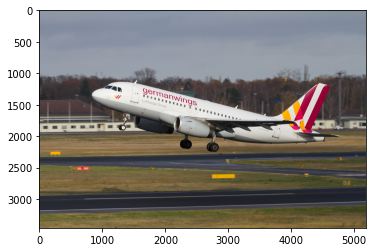

In [ ]:
# Plotting the image
plt.imshow(load_img(get_file('air',im_url)))

<a name='4-2'></a>

### 4.2 Getting a Pretrained ConvNet

We are going load `ResNet50` from `keras.applications.` How cool is it that you can just download a big trained model in a matter of seconds!

We will load it with the ImageNet weights and we will make sure `include_top` is se to `True` since we are ony performing classification and not re-training on our custom dataset.

In [ ]:
# Getting a pretrained model

pretrained_resnet50 = keras.applications.resnet50.ResNet50(weights='imagenet', include_top=True)

<a name='4-3'></a>

### 4.3 Performing Classification

Classifying an image using a pretrained model is easy as saying it. It will take few minutes if you are using GPU.

In [ ]:
predictions = pretrained_resnet50.predict(airplane_image)

Now, let's use `decode_predictions` function to decode the predictions. It will return a list of tuples of class,  label, and probability.

It's important to remember that since ResNet50 we are using was originally trained on ImageNet, the output predictions are for 1000 classes. To get the predicted class, we would need to have a separate list of all classes and find the class with the highest probability but we don't need that now since we can use `decode_predictions` to display the top predictions(can be controlled by `top` parameter) along with their class names.

In [ ]:
# Getting the top 5 predicted classes and their probabilities

preds_decoded = keras.applications.resnet50.decode_predictions(predictions, top=5)[0]

In [ ]:
# Displaying the predictions

i = 1
for tup in preds_decoded:
  print(f'{i} Predicted Class, Label, Prob: {tup}')
  i +=1

1 Predicted Class, Label, Prob: ('n02690373', 'airliner', 0.9895238)
2 Predicted Class, Label, Prob: ('n04592741', 'wing', 0.009582356)
3 Predicted Class, Label, Prob: ('n04552348', 'warplane', 0.0008052158)
4 Predicted Class, Label, Prob: ('n04266014', 'space_shuttle', 5.6901223e-05)
5 Predicted Class, Label, Prob: ('n02687172', 'aircraft_carrier', 1.5924415e-05)


This is pretty amazing. The model(that we never trained ourselves) was able to recognize that the image we fed it is a plane. The label with the high probability is `airliner`, next is `wing`, `warplane`, `space_shuttle` and so forth(be wary that the order of these classes may change but I can guarrantee you to see most of those labels in top 5 predicted labels). We can not blame the model that it recognized wing on airplane :)

This was about using a pretrained model to perform classification without changing anything about it nor retraining it on our custom dataset. What if you wanted to reuse some parts of pretrained model on a custom dataset? That's where transfer learning comes into the picture and it what we will be doing in the following sections.

<a name='5'></a>

## 5. Transfer Learning and Finetuning In Practice

As we said in the previous sections, transfer learning is a technique used in machine learning in which a model developed to perform a given task is reused for another similar task.

In brief, these are steps we take when performing transfer learning:

* Initializing the primary model (often a pretrained model) and weights
* Removing the top layers and freezing the remaining layers of the pretrained model
* Creating the new model by adding new trainable dense layers on top of the primary model
* Training the new model
* Evaluating, and improving (or finetuning) the new model. 

But since we are going to work with our own data this time, let's get and prepare the data first.

<a name='5-1'></a>

### 5.1 Getting the Data

For the purpose of this tutorial, let's use a resonably small dataset. We will use cats and dogs filtered version. The orginal cats and dogs dataset is available on [Kaggle](https://www.kaggle.com/c/dogs-vs-cats) and it is also available in [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs). Hat tip to people that took time to reduce the dataset!

In [ ]:
# Download the data into the workspace

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip


# Extract the zip file

zip_dir = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(zip_dir, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Get training and val directories

main_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(main_dir, 'train')
val_dir = os.path.join(main_dir, 'validation')

--2022-04-08 07:28:14--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 108.177.125.128, 142.250.157.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   102MB/s    in 0.6s    

2022-04-08 07:28:15 (102 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



<a name='5-2'></a>

### 5.2 Applying Data Augmentation

Data augmentation have became a norm in computer vision and it is always helpful whether you have small or enough data.


We are going to use `ImageDataGenerator` to generate augmented images. By augmenting images, we are guarranteed that the model will never see the same image twice. Each image will be transformed into different scenarios and that improves model generalization.


Below are some of the options available in [ImageDataGenerator](https://keras.io/api/preprocessing/image/) and their explanations.

```
train_imagenerator = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
```

* **rotation_range** is a angle value in degrees (0–180) to randomly rotate images.

* **width_shift and height_shift** are ranges of fraction of total width or height within which to translate pictures, either vertically or horizontally.

* **shear_range** is for applying shearing randomly.

* **zoom_range** is for zooming pictures randomly. 

* **horizontal_flip** is for flipping half of the images horizontally. There is also `vertical_flip` option. 

* **fill_mode** is for completing newly created pixels, which can appear after a rotation or a width/height shift.


See the [documentation](https://keras.io/api/preprocessing/image/), it is an interesting read, and there are more preprocessing functions that you might need in your future projects. 

Let's see this in practice! We will start by creating `train_imagenerator` which is an image generator for training set.


In [ ]:
# Creating training image data generator

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_imagenerator = ImageDataGenerator(
    
    rescale=1/255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    
)

We will also create `val_imagenerator`, but different to training generator, there are no augmentation here. Validation data are usually not augmented because it acts as a test data(or unseen data) during the training. If we augment both training and validation data, it might seem everything is going well but it's very likely that the model will not generalize on real(non-augmented images).

For such reason, here we only rescale the validation images pixels to values between 0 and 1. Images pixels are normally between 0 and 255. Rescaling the values improves the performance of the network and reduces training time as well.

In [ ]:
# Validation image generator

val_imagenerator = ImageDataGenerator(rescale=1/255.)

After creating train and validation generators, let's use `image_dataset_from_directory function` to generate a TensorFlow dataset from images files located in our two directories. 

Below is how training and validation directories are structured:

```
cats_dogs_filtered/
..train/
....cats/
......cat.0.jpg
......cat.1.jpg
......cat.2.jpg
....dogs/
......dog.0.jpg
......dog.1.jpg
......dog.2.jpg
..validation/
....cats/
......cat.0.jpg
......cat.1.jpg
....dogs/
......dog.0.jpg
......dog.1.jpg
```

In [ ]:
# Load training images in batches of 32 while applying aumgmentation
train_path = '/tmp/cats_and_dogs_filtered/train'
val_path = '/tmp/cats_and_dogs_filtered/validation'

batch_size = 32
target_size = (224,224)

train_generator = train_imagenerator.flow_from_directory(
        train_path, #parent directory must be specified # or use train_dir
        target_size = target_size, # All images will be resized to (224,224)
        batch_size=batch_size,
        class_mode='binary' # since we need binary labels(0,1) and we will use binary_crossentropy

) 

val_generator = val_imagenerator.flow_from_directory(
        val_path, #parent directory must be specified # or use val_dir
        target_size = target_size, # All images will be resized to (224,224)
        batch_size=batch_size,
        class_mode='binary' # since we need binary labels(0,1) and we will use binary_crossentropy

)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Another great advantage of `ImageDataGenerator` is that it generates the labels of the images based off their folders. During the model training, we won't need to specify the labels.

We are ready to reuse a pretrained model on our dataset, but before we can try to visualize the augmented images.

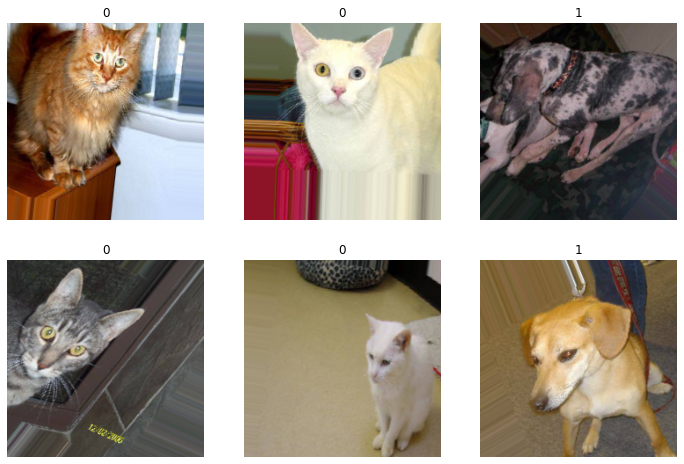

In [ ]:
augmented_image, label = train_generator.next()

plt.figure(figsize=(12,8))
for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(augmented_image[i])
        plt.title(int(label[i]))
        plt.axis("off")

<a name='5-3'></a>

### 5.3 Creating the New Model from the Pretrained Model

We are going to create a new model from a pretrained model. We will use [Xception](https://arxiv.org/abs/1610.02357) as the pretrained model. Don't stress much about which model you should use. If something works on ImageNet, it will likely work on your dataset. 

[keras.applications](https://keras.io/api/applications/) contains many other pretrained models.

One thing to note before we download Xception is that we won't use the top layers or classification head. Usually, CNN architectures are presented from the bottom(input) to top(output layers). We drop the top/classification head by setting `include_top` parameter to `False`.

The reason for dropping the top layers make sense. Orginally, the pretrained model was trained on large dataset called `ImageNet`. ImageNet has 1000 classes. Our task is to classify cats and dogs, and so we have 2 classes. In a pretrained ResNet50(or any CNN in general), the top layers are very specifc to ImageNet 1000 classes. To adapt to network to out dataset, we will simply get rid of classification head and add our own custom layers. In finetuning section, we will also see that sometime it's better to also retrain other layers that are close to the top because they contain high-level features(kind of features that are very specific to the dataset). 

In [ ]:
pretrained_base_model = keras.applications.Xception(
    weights='imagenet',
    include_top=False, # Drop imagenet classifier on the top
    input_shape=(224,224,3)

)

We then freeze the pretrained base model to avoid retraining the bottom layers.

In [ ]:
for layer in pretrained_base_model.layers:
  layer.trainable = False

We can display the summary of the pretrained with `pretrained_base_model.summary()`.

In [ ]:
#pretrained_base_model.summary()

Or plot it with `keras.utils.plot_model()`

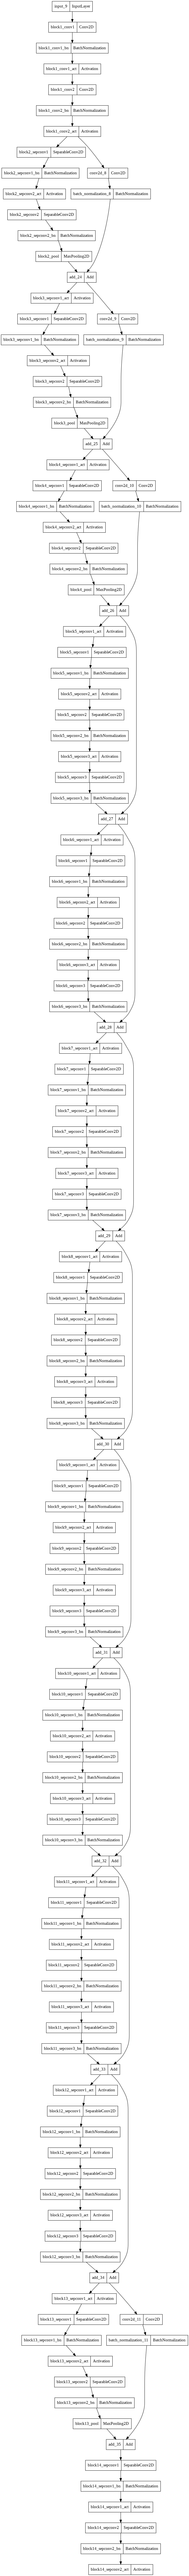

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(pretrained_base_model)

We can now create our new model. Different to [Sequential API](https://www.tensorflow.org/guide/keras/sequential_model), we are going to use [Functional API](https://www.tensorflow.org/guide/keras/functional). Sequential API make it simple to stack layers, from the input to output, no other way around. With Functional API, you can stack the layers in a fashion you want!

Functional API is a preferrable model building API in tasks that take multiple inputs or give multiple outputs. A good example for these type of tasks is object detection, where you have to predict both the class of the object and the bounding boxes. It's also useful when building network that has residual connections like ResNet.

That was few notes about Sequential/Functional API.

In [ ]:
# Define the input shape
inputs = tf.keras.Input(shape=(224, 224, 3))

# Pass the inputs to pretrained model and set training to false
x = pretrained_base_model(inputs, training=False)

# Add a pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Add a dropout layer for regularization purpose: 0.5 dropout rate is a good default
x = tf.keras.layers.Dropout(0.5)(x)

# Last output dense layer with 1 unit. 
# An activation function is not necessary since the predictions are already logit
output = tf.keras.layers.Dense(1)(x)

# Build a model
model = tf.keras.Model(inputs, output)

Here is a summary of the new model.

In [ ]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_7   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
___________________________________________

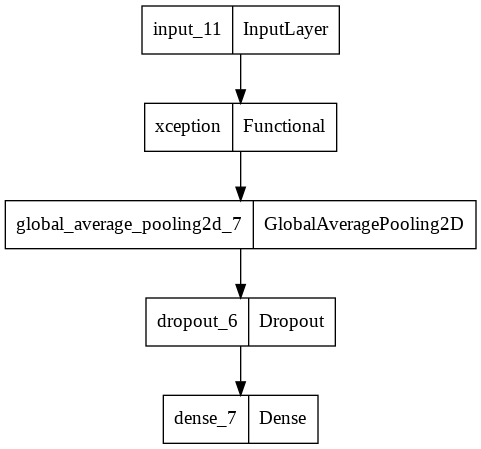

In [ ]:
plot_model(model)

<a name='5-4'></a>

### 5.4 Compiling and Training a New Model

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

batch_size = 32

train_steps = 2000/batch_size
val_steps = 1000/batch_size

history = model.fit(
      train_generator,
      steps_per_epoch=train_steps,  
      epochs=13,
      validation_data=val_generator,
      validation_steps=val_steps)

Epoch 1/13
62/62 [==============================] - 49s 720ms/step - loss: 0.2883 - accuracy: 0.8690 - val_loss: 0.0841 - val_accuracy: 0.9830
Epoch 2/13
62/62 [==============================] - 44s 699ms/step - loss: 0.1280 - accuracy: 0.9505 - val_loss: 0.0578 - val_accuracy: 0.9840
Epoch 3/13
62/62 [==============================] - 44s 705ms/step - loss: 0.0969 - accuracy: 0.9645 - val_loss: 0.0495 - val_accuracy: 0.9840
Epoch 4/13
62/62 [==============================] - 44s 703ms/step - loss: 0.0891 - accuracy: 0.9685 - val_loss: 0.0443 - val_accuracy: 0.9840
Epoch 5/13
62/62 [==============================] - 43s 690ms/step - loss: 0.0896 - accuracy: 0.9650 - val_loss: 0.0410 - val_accuracy: 0.9850
Epoch 6/13
62/62 [==============================] - 43s 694ms/step - loss: 0.0749 - accuracy: 0.9705 - val_loss: 0.0391 - val_accuracy: 0.9850
Epoch 7/13
62/62 [==============================] - 43s 692ms/step - loss: 0.0862 - accuracy: 0.9625 - val_loss: 0.0411 - val_accuracy: 0.9860

<a name='5-5'></a>

### 5.5 Visualizing the Results

In [ ]:
# function to plot accuracy & loss

def plot_acc_loss(history):

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = history.epoch

  plt.figure(figsize=(10,5))
  plt.plot(epochs, acc, 'r', label='Training Accuracy')
  plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc=0)

  # Create a new figure with plt.figure()
  plt.figure()

  plt.figure(figsize=(10,5))
  plt.plot(epochs, loss, 'b', label='Training Loss')
  plt.plot(epochs, val_loss, 'y', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(loc=0)
  plt.show()

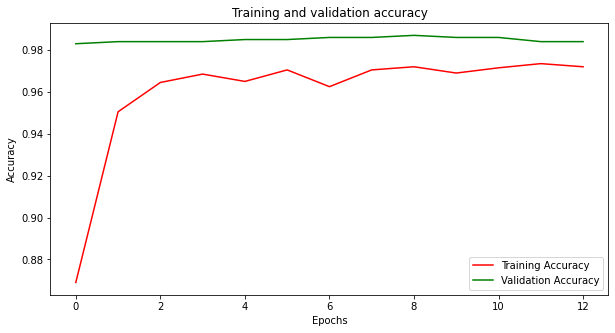

<Figure size 432x288 with 0 Axes>

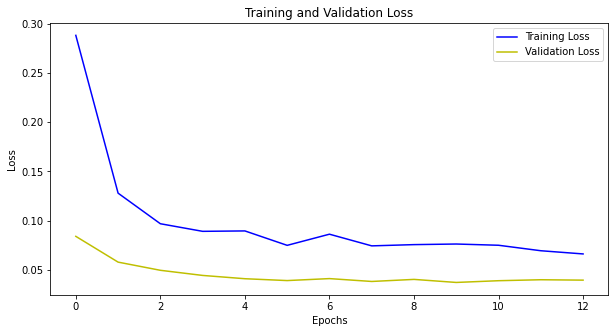

In [ ]:
plot_acc_loss(history)

It's pretty impressive how the new model did. Because the bottom layers had some learned weights (the advantages of using pretrained models), training accuracy started at 88% and val accuracy at 97%(approximately).

Another point to make is that the validation metrics are good than training metrics. The reason why validation accuracy is better than training accuracy, or why validation loss is less than training loss, it's because the pretrained model has batch normalization and dropout layers. These regularization layers affects the accuracy during training, but they are turned off during validation. Those regularization layers makes it hard for a model to learn during training but they are off during test time, so the model has much freedom at test time :) 

Also, during the training, accuracy and loss are averaged per epoch, while during validation phase, accuracy and loss are computed on a model that has already trained longer.
You can notice this if you keep the eye on progress bar during the training. The training metrics change per step/epoch, and at the end of the epoch, the average loss/accuracy are reported. On the other hand, the validation metrics are computed after training on each epoch.



<a name='5-6'></a>

### 5.6 Finetuning the Model

All we did so far is to only train the new layers we added. In order to improve the performance, we can try to train some more top layers. We only just have to unfreeze the layers we want to train and that will be it!

Here is the reason: In any typical CNN architecture, the more the layers go to top, the more specialized they become on the dataset. The first layers (from the bottom) learns the low level features that are almost same for all datasets (lines, edges, blobs), but as the layers go up, they start to learn high level features that are specific to the dataset. Since our pretrained model was trained on imagenet, the high level features may mean things like faces, nose, ears, wings, etc...

We clearly don't need to have those high-level features in our little problem(dog vs cat). We can look for layers that contain middle-level features and start training there.

Since we are going to retrain some part of the pretrained model again, let's set it to trainable.

In [ ]:
pretrained_base_model.trainable = True

In [ ]:
# Define the input shape
inputs = tf.keras.Input(shape=(224, 224, 3))

# stack the inputs to pretrained model and set training to false
x = pretrained_base_model(inputs, training=False)

# Add a pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Add a dropout layer

x = tf.keras.layers.Dropout(0.5)(x)

# Last output dense layer with 1 unit. An activation function is not necessary since the predictions are already logit
output = tf.keras.layers.Dense(1)(x)

# Build a model
model = tf.keras.Model(inputs, output)

In [ ]:
# Number of layers in pretrained model

len(pretrained_base_model.layers)

132

Now, we are going to freeze the first 100 layers(from the bottom/input of the pretrained model), and we will train the remaining 32 layers. 

In [ ]:
# Freeze the first 100 layers 

for layer in pretrained_base_model.layers[:100]:

  layer.trainable = False

We can now compile the model again. But this time, we will use low learning rate. Quoting [CS231n](https://cs231n.github.io/transfer-learning/) for why we use low learning rates in fine-tuning ConvNets:
>" It’s common to use a smaller learning rate for ConvNet weights that are being fine-tuned, in comparison to the (randomly-initialized) weights for the new linear classifier that computes the class scores of your new dataset. This is because we expect that the ConvNet weights are relatively good, so we don’t wish to distort them too quickly and too much (especially while the new Linear Classifier above them is being trained from random initialization)."

Think the linear classifier mentioned above as a new classification head(mostly made of fully connected layers) we replaced with the top of the network.

The default learning rate in Adam is `0.001`. Let's set it to `1e-5` for now. You can try other values such as [this](https://twitter.com/karpathy/status/801621764144971776?lang=en).

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

And we will train for 7 epochs. It doesn't make difference to specify training and validation steps since the data are already in batches.

In [ ]:
history = model.fit(
      train_generator,
      epochs=7,
      validation_data=val_generator)

Epoch 1/7
63/63 [==============================] - 57s 839ms/step - loss: 0.5114 - accuracy: 0.7335 - val_loss: 0.1997 - val_accuracy: 0.9600
Epoch 2/7
63/63 [==============================] - 47s 752ms/step - loss: 0.1724 - accuracy: 0.9365 - val_loss: 0.0620 - val_accuracy: 0.9810
Epoch 3/7
63/63 [==============================] - 48s 758ms/step - loss: 0.0932 - accuracy: 0.9610 - val_loss: 0.0471 - val_accuracy: 0.9850
Epoch 4/7
63/63 [==============================] - 48s 753ms/step - loss: 0.0737 - accuracy: 0.9660 - val_loss: 0.0333 - val_accuracy: 0.9870
Epoch 5/7
63/63 [==============================] - 48s 756ms/step - loss: 0.0658 - accuracy: 0.9720 - val_loss: 0.0481 - val_accuracy: 0.9850
Epoch 6/7
63/63 [==============================] - 47s 749ms/step - loss: 0.0675 - accuracy: 0.9740 - val_loss: 0.0317 - val_accuracy: 0.9870
Epoch 7/7
63/63 [==============================] - 48s 753ms/step - loss: 0.0599 - accuracy: 0.9755 - val_loss: 0.0275 - val_accuracy: 0.9910


<a name='5-7'></a>

### 5.7 Vizualizing the Results Again

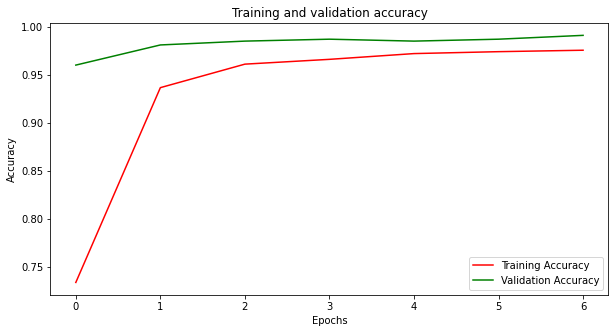

<Figure size 432x288 with 0 Axes>

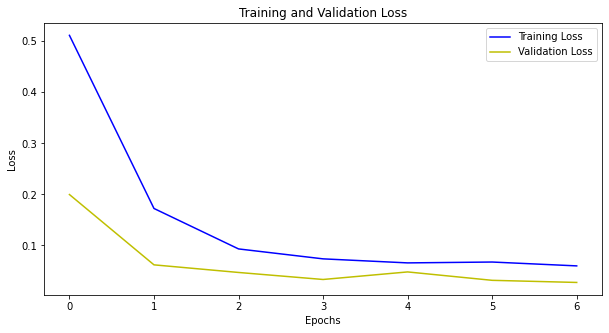

In [ ]:
plot_acc_loss(history)

This is very much better. There is no significant increase in accuracy but the learning curve is much smoother. The reason validation metrics still looks better than training metrics is because of regularization layers(dropout & batch normalization) that are not active during test time.

<a name='6'></a>

## 6. Image Classification and Transfer Learning with TensorFlow Hub

[TensorFlow Hub](https://www.tensorflow.org/hub) is a repository of trained and ready to use machine learning models in wide-variety of fields such as computer vision(image classification, object detection, image segmentation...) and natural language processing(sentiment analysis, speech recognition, text classification, etc...).

You can use models in TensorFlow Hub as they are or finetune them.

Something that's also nice about TF Hub is that it contains models with different formats. Beyond normal model format, there are also models for JavaScript([tf-js](https://www.tensorflow.org/js)) and [TF Lite](https://www.tensorflow.org/lite)(for mobile phone and edge devices).

<a name='6-1'></a>

### 6.1 Image Classification with TensorFlow Hub

The fact that all models in TF Hub are trained, it means that you can use them in things like image classification without having to do anything, other than loading a model, preprocessing your images, and making predictions right away.

Beyond downloading an image, TensorFlow Team even took a step further. You can upload your image in a browser and get a reasonable predictions of the image label. You can try it [here](https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5)

How cool is that!!

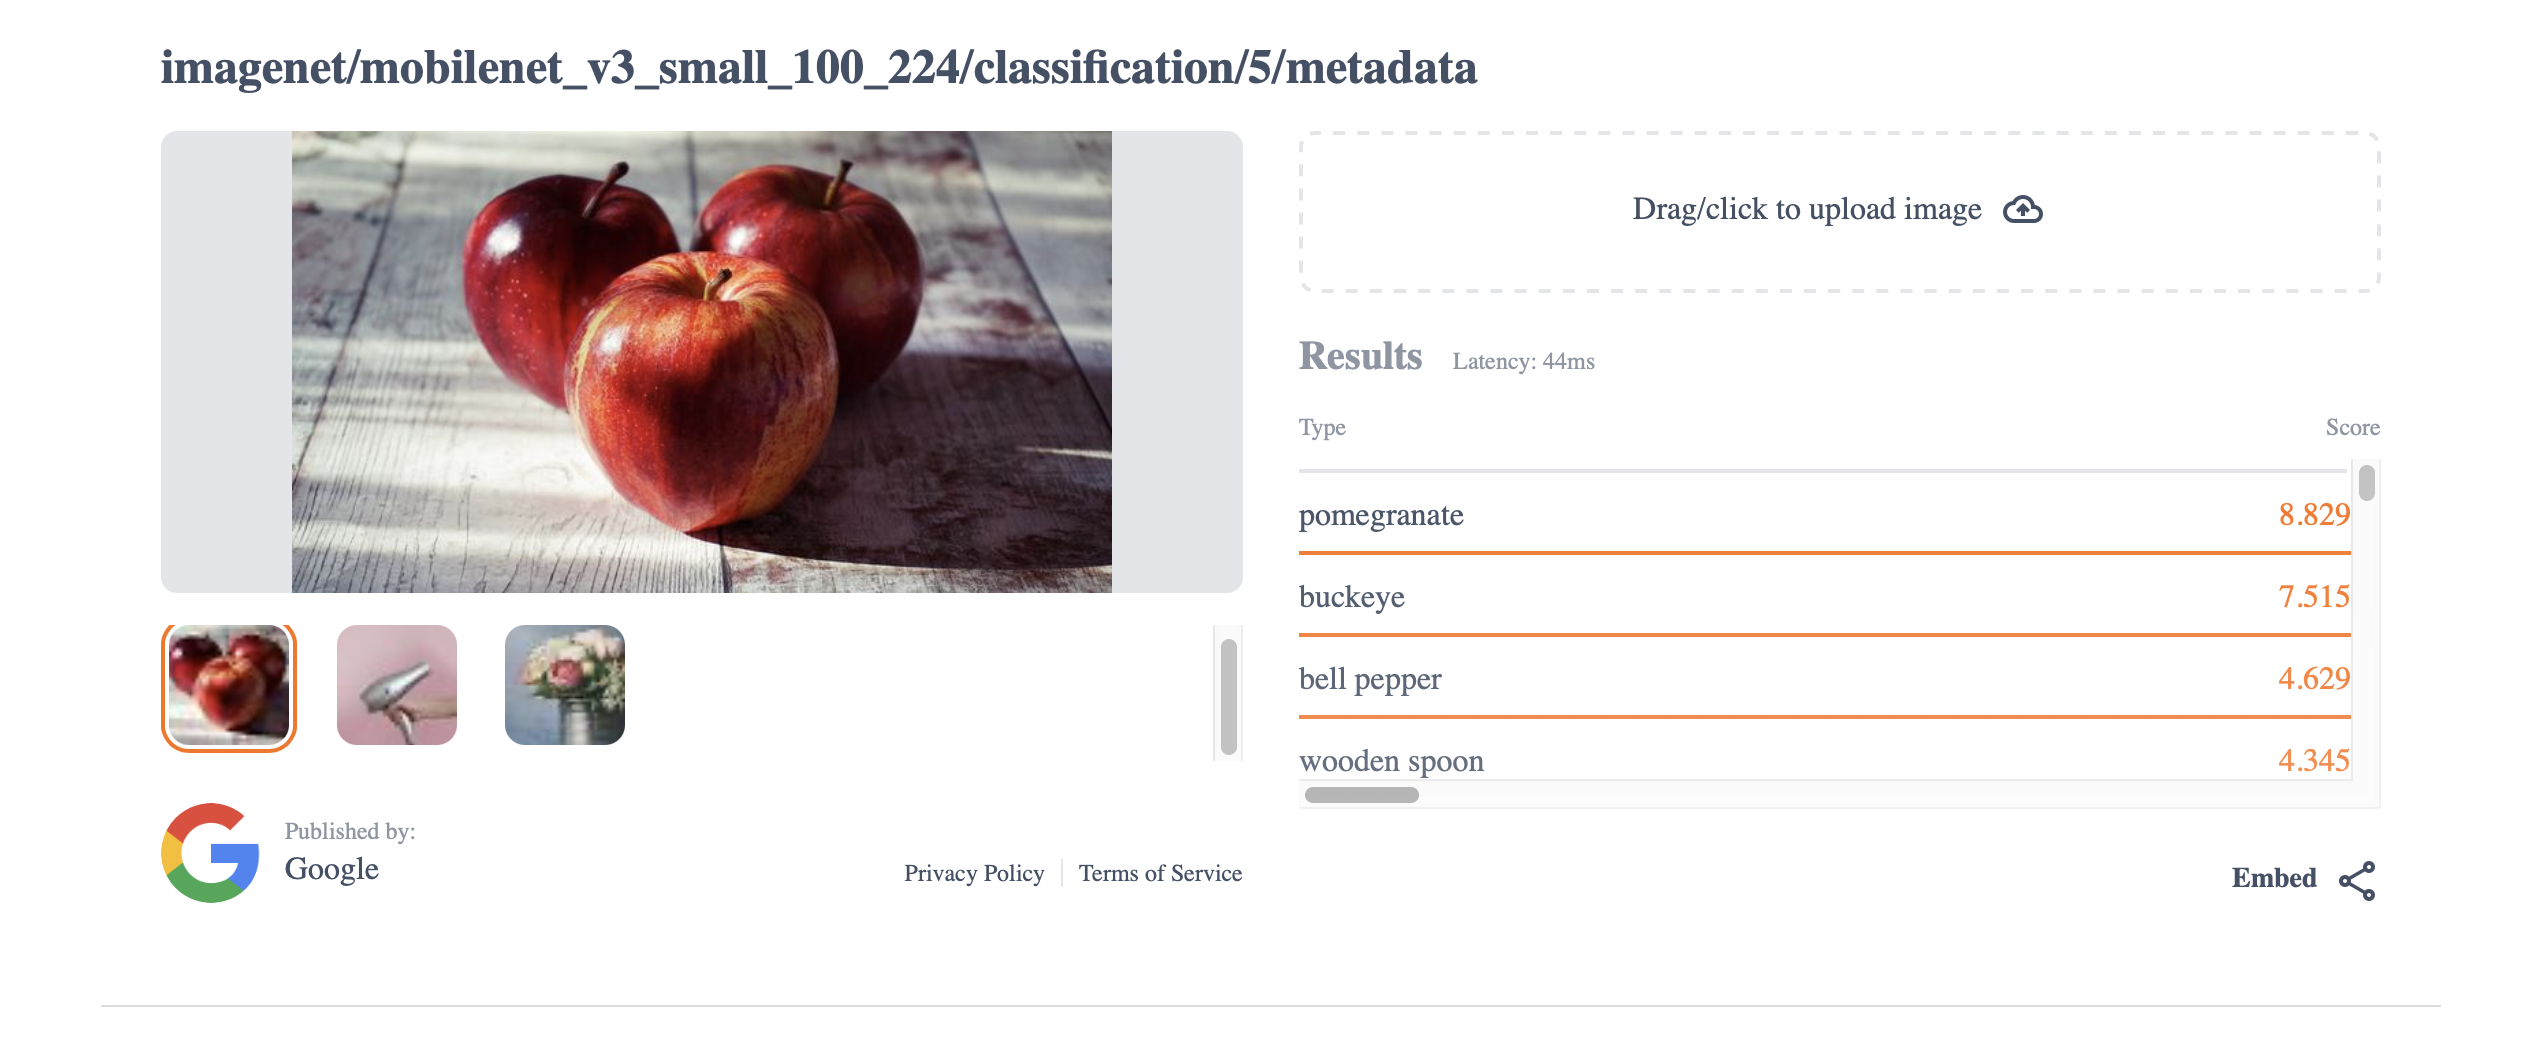

Let's do some practice again! We will start by loading the pretrained ConvNet from TensorFlow Hub.

<a name='6-1-1'></a>

#### 6.1.1 Getting a Pretrained Model


In this quest of image classification with TF Hub, we will use MobileNetV3. 

[MobileNetV3](https://arxiv.org/abs/1905.02244) is a CNN type architecture built for performing efficient on-device image classification. It's not limited to classification, it can also be used for things like object detection and image segmentation.

The next time you want to deploy an image classifier in a mobile device with a latency and performance tradeoff, consider MobileNet models. 

We will use a small version of MobileNet, but there is a [large version](https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5) for high resources applications.

In [ ]:
# Getting MobileNetV3 model from Hub

model_url = 'https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5'
classifier = hub.load(model_url)

I find it cool to just get the whole trained model with one line of code, it's basically like downloading an image from the internet.

<a name='6-1-2'></a>

#### 6.1.2 Getting and Preparing Image

The model expect the image to have the size of (224,224,3). Let's download an image and preprocess it accordingly.

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import get_file

def get_preprocess_image(image_name, image_url):

  '''Download an image and return preprocessed image'''

  image = get_file(image_name, image_url)
  image = load_img(image, target_size=(224,224))
  image = img_to_array(image)
  image = image/255.0
  image = tf.expand_dims(image, 0)
  
  return image

In [ ]:
# Test images url

bus = 'https://upload.wikimedia.org/wikipedia/commons/6/63/LT_471_%28LTZ_1471%29_Arriva_London_New_Routemaster_%2819522859218%29.jpg'
tiger = 'https://upload.wikimedia.org/wikipedia/commons/b/b0/Bengal_tiger_%28Panthera_tigris_tigris%29_female_3_crop.jpg'
cat = 'https://upload.wikimedia.org/wikipedia/commons/4/4d/Cat_November_2010-1a.jpg'
car = 'https://upload.wikimedia.org/wikipedia/commons/4/49/2013-2016_Toyota_Corolla_%28ZRE172R%29_SX_sedan_%282018-09-17%29_01.jpg'
dog = 'https://upload.wikimedia.org/wikipedia/commons/archive/a/a9/20090914031557%21Saluki_dog_breed.jpg'

In [ ]:
# Get and preprocess image
image = get_preprocess_image('dog', dog)

# Get shape of the image 
image.shape

TensorShape([1, 224, 224, 3])

<a name='6-1-3'></a>

#### 6.1.3 Running a Classifier on Image

In [ ]:
# Making predictions
predictions = tf.nn.softmax(classifier(image))

# Converting predictions to numpy array and returning the top-5
predictions = predictions.numpy()
predictions[:5]

array([[2.4639015e-04, 4.2892450e-05, 2.0482690e-05, ..., 1.6945181e-04,
        3.4929748e-04, 3.1921675e-04]], dtype=float32)

Pretty cool, right? Now we finished predicting the image and we have predictions. It doesn't make sense though. 

Let'd download the class names. MobileNet V3 was trained on ImageNet which has 1000 classes, but because there is additional background class, the total number of classes is 1001.

Let's download the classes file and since the downloaded file is a text type, we will convert it into a Python list. So, we are going to get a list of all classes.

In [ ]:
classes_file = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
class_names_file = get_file('classes',classes_file)

# Read file
file = open(class_names_file,'r')

# Get a list of class names
classes =  [label.strip() for label in file.readlines()]
file.close()

# Remove the class of background which is at index 0. It is not included in predictions
classes = classes[1:]

# Display top 5 classes (by index)
len(classes)

24576/10484 [======================================================================] - 0s 0us/step


1000

Pretty cool. Let's use class names along with the predictions of the image we got.

In [ ]:
# Get top 5 predictions

top_5_preds = tf.argsort(predictions, axis=-1, direction='DESCENDING')[0][:5].numpy()

for i, item in enumerate(top_5_preds):
  print(f"Class index: {item}, Class name:{str(classes[item])}, Probability: {predictions[0][top_5_preds][i]}")

Class index: 237, Class name:miniature pinscher, Probability: 0.21660542488098145
Class index: 177, Class name:Scottish deerhound, Probability: 0.2060239166021347
Class index: 215, Class name:Brittany spaniel, Probability: 0.19848179817199707
Class index: 166, Class name:Walker hound, Probability: 0.04971788451075554
Class index: 235, Class name:German shepherd, Probability: 0.04807565361261368


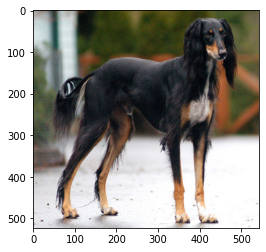

In [ ]:
# display image

plt.imshow(load_img(get_file('dog',dog)))

<a name='6-1-4'></a>

#### 6.1.4 Wrapping-Up A TF Hub Model Into a Keras Layer

Another interesting thing about TF hub models is that they can be wrapped in Keras layer. 

In [ ]:
mobilenet_large = 'https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5'

clf_model = tf.keras.Sequential([
       hub.KerasLayer(mobilenet_large, input_shape=(224,224,3))                          

])

Now you can make predictions on images as usual with Keras models. 

In [ ]:
# Get and preprocess an image

image = get_preprocess_image('cat', cat)

2842624/2833605 [==============================] - 0s 0us/step


In [ ]:
preds = clf_model.predict(image)

In [ ]:
# Get the top class with tf.argmax() or np.argmax()

predicted_class = tf.argmax(preds[0], axis=-1)

# Get predicted class name from imagenet labels

predicted_class_name = classes[predicted_class]
predicted_class_name

'Persian cat'

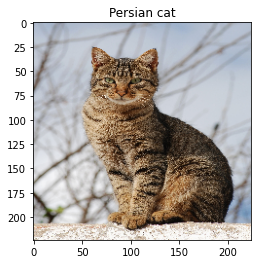

In [ ]:
#Plot image and predicted class name

plt.imshow(np.reshape(image, (224,224,3)))
plt.title(predicted_class_name);

<a name='6-2'></a>

### 6.2 Building a Custom Classifier with TF Hub

TensorFlow Hub contains many models that are trained and ready to be used. 

Some of the available pretrained models can be used for direct classification without having to add anything. Just like we did above, we can either use these models by loading them or we can wrap them in keras layer. 

In this final section, let's do something different, and also, let's take a different dataset: We are going to customize TF Hub models on [flower datasets](https://www.tensorflow.org/datasets/catalog/tf_flowers). 

`tf_flower` dataset is a large set of image of flowers.  

By the end, you will have learned to work with tensorflow datasets and how to reuse pretrained models on new data (transfer learning). 




<a name='6-2-1'></a>

#### 6.2.1 Getting and Preparing Data

Let's load `tf_flowers` dataset from TensorFlow datasets. As we load the data, we will split it into train, test, and validation sets. 

Flower dataset contains 3670 images. Training set will take 80% of the dataset, and validation set 20%. Instead of reserving a test set, we will test the model on the internet images.

In [ ]:
# Loading the data from tensorflow datasets

(train_data, val_data), flower_info = tfds.load('tf_flowers',
                                              split=['train[:80%]', 'train[80%:]'],
                                              with_info=True,
                                              as_supervised=True,
                                              shuffle_files=True
)


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


Now that the data is downloaded, we can see the number of images in each set.

In [ ]:
# Number of images in train, test, val
total_images = flower_info.splits['train'].num_examples # there is orginally one split ['train']


print(f'Total number of images: {total_images}')
print(f'The number of images in training set: {len(train_data)}')
print(f'The number of images in validation set set: {len(val_data)}')

Total number of images: 3670
The number of images in training set: 2936
The number of images in validation set set: 734


And we can also see the classes or categories we have.

In [ ]:
cat_names = flower_info.features['label'].names

print(f'Categories of flowers: {cat_names}\n Number of categories: {len(cat_names)}')

Categories of flowers: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
 Number of categories: 5


##### Looking into Data

As always, it's best to visualize the data. 

For simplicity, we can first display some images using [tfds.visualization.show_examples](https://www.tensorflow.org/datasets/api_docs/python/tfds/visualization/show_examples)

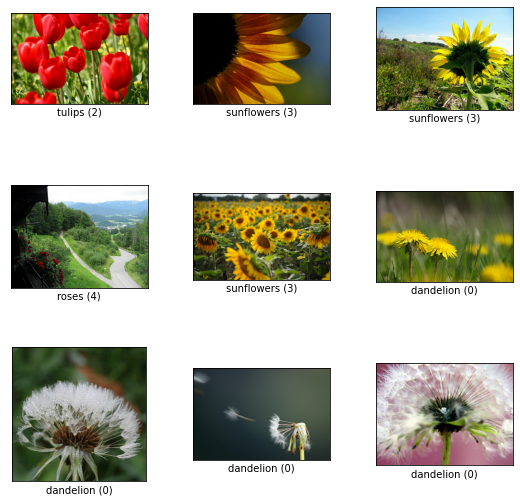

In [ ]:
plot_images = tfds.show_examples(train_data, flower_info)

If you want to look at more images, you can use Matplotlib to plot the images.

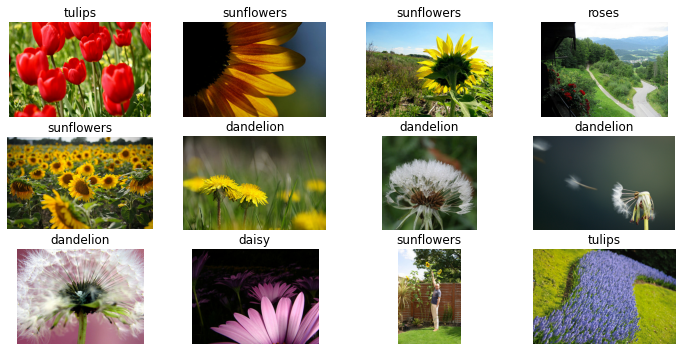

In [ ]:
plt.figure(figsize=(12,8))

index = 0

for image, label in train_data.take(12):
  
  index += 1
  plt.subplot(4,4,index)
  plt.imshow(image)
  plt.title(cat_names[label])
  plt.axis('off')

Now that we loaded and looked into the data, it's time to do some little preprocessing. We are going to normalize the images and we will also resize images to have (224, 224). 

Keras has [preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) that we can use either inside the model (take advantage of GPU) or use outside the model.

In [ ]:
def preprocess(image, label):

  image = tf.cast(image, tf.float32)/255.0
  image = tf.image.resize(image, (224,224))

  return image, label

Now, we can apply the above function to the dataset with [map function](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map). We will also shuffle images, and put them into batches.

Note that we do not shuffle the validation set.

In [ ]:
def train_prep(data, shuffle_size, batch_size):

  data = data.map(preprocess)
  data = data.cache()
  data = data.shuffle(shuffle_size).repeat()
  data = data.batch(batch_size)
  data = data.prefetch(1)

  return data

In [ ]:
def val_prep(data, batch_size):

  data = data.map(preprocess)
  data = data.batch(batch_size)
  data = data.cache()
  data = data.prefetch(1)

  return data

In [ ]:
train_ds = train_prep(train_data, 1000, 32)
val_ds = val_prep(val_data, 32)

Let's verify if our images are resized to (224,224) and if the pixel values are scaled to be in the range of 0 and 1. 

In [ ]:
for image,label in train_ds.take(1):
  print(f'Images shape(batch size, width, height, color channel):{image.shape}')
  print(f'The label of the first image in batch: {label[0]}')
  print(image[0,0:2])
  
  break

Images shape(batch size, width, height, color channel):(32, 224, 224, 3)
The label of the first image in batch: 2
tf.Tensor(
[[[0.54260266 0.60899866 0.10938814]
  [0.53128815 0.59820336 0.09585803]
  [0.53182185 0.6055382  0.11450707]
  ...
  [0.7402489  0.5780112  0.45022792]
  [0.7295833  0.56474084 0.4484662 ]
  [0.7030683  0.5509676  0.43181485]]

 [[0.4662637  0.5536237  0.09473696]
  [0.48281217 0.5630953  0.08726928]
  [0.49140126 0.57753634 0.10937937]
  ...
  [0.69033545 0.5517335  0.42415965]
  [0.6674719  0.5406409  0.41831633]
  [0.6294397  0.51221293 0.3941491 ]]], shape=(2, 224, 3), dtype=float32)


As you can see, everything is cool now. All images are resized to (224,224) and rescaled to (0,1). We are ready to go!

Now we can follow with creating new model from a pretrained model.

<a name='6-2-2'></a>

#### 6.2.2 Creating a New Model from a Pretrained Model

In this section, we will load a pretrained model from TensorFlow hub. 

There is something different to what we have done in previous sections. 

Instead of using a whole model trained on imagenet, we will take a model without classification layers (normally called fully connected layers or linear classifier) and add our own classification layer that is relevant to the task we are doing which is classifying flowers. 

If you can remember, with normal pretrained models available in [Keras applications](https://keras.io/api/applications/), we would have to set `include_top` to `False` in order to use the pretrained model as a feature extractor without an imagenet classification layers. Fortunately, TensorFlow Hub contains feature extractors, so we don't have to worry getting the rid of the top layers.

In TensorFlow Hub, the pretrained models that are used for feature extractions are very clear looking in the their model handle. Take an example: 

**MobilenetV3 Large Feature Extractor**: https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5

**MobileNetV3 Large Classification**: https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/classification/5

Now that we understand the essence of TF Hub models, let's get a MobileNetv3 feature extractor. Any feature extractor from TF Hub can work here. 

We will then stack it in [KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer), and make sure it is not trainable. We will only train the classification layer that we will add later.

In [ ]:
model_handle = 'https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5'

feature_extractor = hub.KerasLayer(
    model_handle,
    input_shape = (224,224,3),
    trainable = False
)

We are now going to add a classification layer. Our flower dataset has 5 classes, so we will have 5 units/neurons in final dense layer.

In [ ]:
flower_classifier = tf.keras.Sequential([
     # MobileNetv3 Feature Extractor

     feature_extractor,

     # Classification layer, activation function is not necessary
     tf.keras.layers.Dense(5)                     

])

We can see the model summary

In [ ]:
flower_classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2731616   
                                                                 
 dense_9 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,738,021
Trainable params: 6,405
Non-trainable params: 2,731,616
_________________________________________________________________


<a name='6-2-3'></a>

#### 6.2.3 Compiling and Training a New Model

After we have created the model, the next step is always to compile it. 

In model compilation, it's where we specify the loss, optimizer, and performance metric that we want to track during the training. 

Loss function is there to measure the distance between the prediction and actual output, and optimizer is for minimizing the loss. There are a whole maths behind loss and optimization functions, but that's the high-level idea. 

We are going to train the new model we created from a pretrained feature extractor. That's means fitting it on the data. 

In [ ]:
# Compiling the model 

flower_classifier.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.02),
    metrics=['accuracy']

)

In [ ]:
batch_size = 32
train_steps = int(len(train_data)/batch_size)
val_steps = int(len(val_data)/batch_size)


history_flower = flower_classifier.fit(
      train_ds,
      steps_per_epoch=train_steps,
      validation_data=val_ds,
      validation_steps=val_steps,
      epochs=15
)

Epoch 1/15
91/91 [==============================] - 18s 113ms/step - loss: 0.7605 - accuracy: 0.7548 - val_loss: 0.4928 - val_accuracy: 0.8438
Epoch 2/15
91/91 [==============================] - 8s 86ms/step - loss: 0.4205 - accuracy: 0.8702 - val_loss: 0.3886 - val_accuracy: 0.8793
Epoch 3/15
91/91 [==============================] - 8s 86ms/step - loss: 0.3377 - accuracy: 0.8990 - val_loss: 0.3433 - val_accuracy: 0.8892
Epoch 4/15
91/91 [==============================] - 8s 87ms/step - loss: 0.2993 - accuracy: 0.9124 - val_loss: 0.3175 - val_accuracy: 0.8935
Epoch 5/15
91/91 [==============================] - 8s 87ms/step - loss: 0.2702 - accuracy: 0.9196 - val_loss: 0.3010 - val_accuracy: 0.9020
Epoch 6/15
91/91 [==============================] - 8s 87ms/step - loss: 0.2482 - accuracy: 0.9289 - val_loss: 0.2892 - val_accuracy: 0.9006
Epoch 7/15
91/91 [==============================] - 8s 87ms/step - loss: 0.2309 - accuracy: 0.9334 - val_loss: 0.2792 - val_accuracy: 0.9048
Epoch 8/15


Now that the model is trained, let's plot the results with the function that we created earlier: `plot_acc_loss(history)`.

<a name='6-2-4'></a>

#### 6.2.4 Visualizing the Results

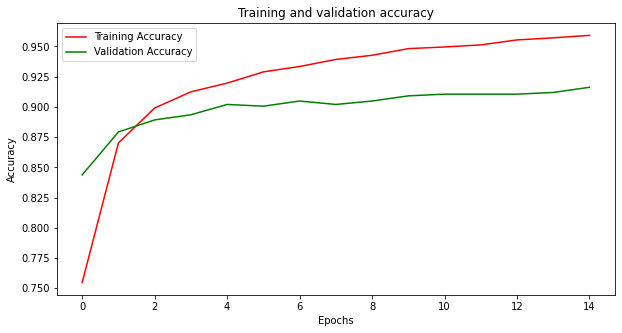

<Figure size 432x288 with 0 Axes>

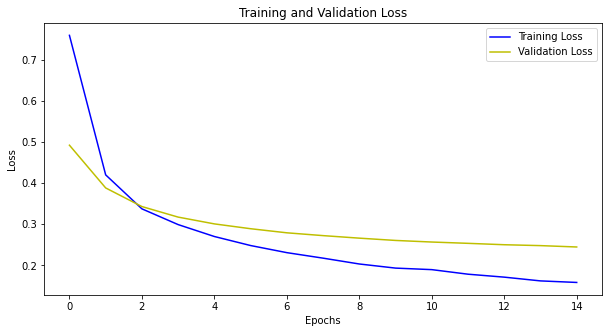

In [ ]:
plot_acc_loss(history_flower)

Looking on the validation and training curves, there is a big gap between training metrics and validation metrics. Clearly, this is a sign of overfitting. There are many techniques that are used for avoiding overfitting such as adding more data, augmenting the existing data, using some regularization techniques such as dropout.

Let's do some finetuning. We will add dropout layer for regularization, change optimizer to Adam and use lower learning rate.

Epoch 1/15
91/91 [==============================] - 10s 94ms/step - loss: 1.2063 - accuracy: 0.5244 - val_loss: 0.7891 - val_accuracy: 0.7599
Epoch 2/15
91/91 [==============================] - 8s 85ms/step - loss: 0.7073 - accuracy: 0.7665 - val_loss: 0.5642 - val_accuracy: 0.8366
Epoch 3/15
91/91 [==============================] - 8s 85ms/step - loss: 0.5392 - accuracy: 0.8238 - val_loss: 0.4663 - val_accuracy: 0.8580
Epoch 4/15
91/91 [==============================] - 8s 86ms/step - loss: 0.4663 - accuracy: 0.8486 - val_loss: 0.4093 - val_accuracy: 0.8707
Epoch 5/15
91/91 [==============================] - 8s 86ms/step - loss: 0.4073 - accuracy: 0.8664 - val_loss: 0.3747 - val_accuracy: 0.8807
Epoch 6/15
91/91 [==============================] - 8s 85ms/step - loss: 0.3625 - accuracy: 0.8856 - val_loss: 0.3477 - val_accuracy: 0.8864
Epoch 7/15
91/91 [==============================] - 8s 85ms/step - loss: 0.3373 - accuracy: 0.8877 - val_loss: 0.3297 - val_accuracy: 0.8878
Epoch 8/15
9

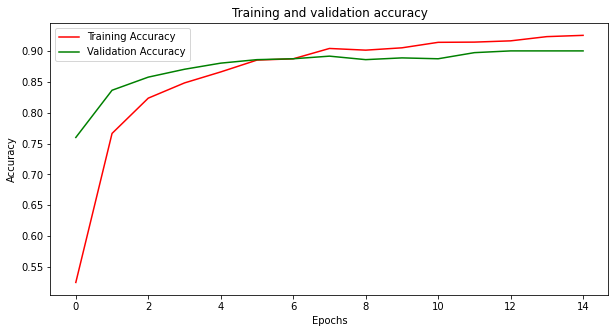

<Figure size 432x288 with 0 Axes>

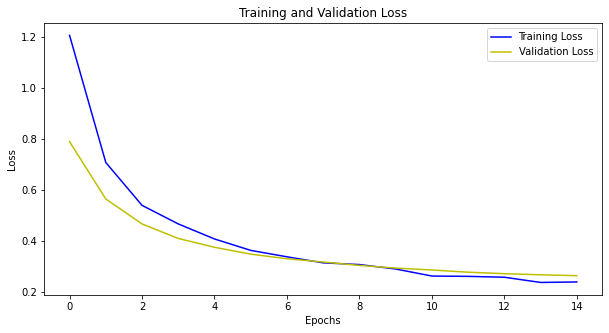

In [ ]:
flower_classifier = tf.keras.Sequential([
     # MobileNetv3 Feature Extractor
     feature_extractor,

     # Dropout for regularization
     tf.keras.layers.Dropout(0.4),
     
     # Classification layer, activation function is not necessary
     tf.keras.layers.Dense(5)                     
])

# Compiling the model 

flower_classifier.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4), #lower learning rate is better in transfer learning
    metrics=['accuracy']

)

# Training the finetuned model

history_flower = flower_classifier.fit(
      train_ds,
      steps_per_epoch=train_steps,
      validation_data=val_ds,
      validation_steps=val_steps,
      epochs=15
)

# Plot the finetuned results.
plot_acc_loss(history_flower)

This is much better for sure! We are no longer overfitting! 

<a name='6-2-5'></a>

#### 6.2.5 Testing a Model on New Internet Images

In [ ]:
def test_model(model, image_url, image_name):

  '''
    Take a model, image url, image_name,
    preprocess the image (resize, rescale),
    predict the label of the image,
    and return the predicted label of the image
  '''

  image = tf.keras.utils.get_file(image_name, image_url)
  image = tf.keras.preprocessing.image.load_img(image, target_size=(224,224))
  image = tf.keras.preprocessing.image.img_to_array(image)
  image = image/255.0
  image = tf.expand_dims(image, 0)

  # predict the label of the image
  pred = model.predict(image)

  # Get the top predicted label
  pred_label = tf.argmax(pred[0],axis=-1)

  return pred_label

In [ ]:
image_url = 'https://upload.wikimedia.org/wikipedia/commons/f/f9/Tulip_cv._04.JPG'

predicted_label = test_model(flower_classifier, image_url, 'im_name')
print(predicted_label)

2457600/2445988 [==============================] - 2s 1us/step
tf.Tensor(2, shape=(), dtype=int64)


The predicted label/class is 2. Let's look into the names of the categories to see the name of the predicted label. 

In [ ]:
print(f'Predicted class: {predicted_label} \nPredicted flower name: {cat_names[predicted_label]}')

Predicted class: 2 
Predicted flower name: tulips


The predicted class is `tulip`. Let's plot the image and it's predicted label to verify the correctness of our classifier!

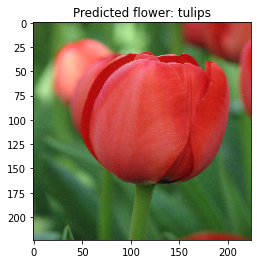

In [ ]:
plt.imshow(load_img(get_file('image', image_url), target_size=(224,224)));
plt.title(f'Predicted flower: {cat_names[predicted_label]}');

Our flower classifier is quite smart! It recognized that the test image(we downloaded from the internet) is [tulip](https://en.wikipedia.org/wiki/Tulip).

This is the end of the notebook that was about transfer learning with pretrained convolutional neural networks from Keras and TensorFlow Hub.

<a name='7'></a>

## 7. Further Learning

#### TensorFlow and Keras Officials:

* [Transfer Tutorials](https://www.tensorflow.org/tutorials)
* [Keras Code Examples](https://keras.io/examples/)
* [TensorFlow Hub](https://www.tensorflow.org/hub)

#### Readings(Optional)

* [Transfer Learning - CS231n](https://cs231n.github.io/transfer-learning/)(Hat tip to [Karpathy](https://karpathy.ai) for well curated note on transfer learning)
* [Rethinking ImageNet Pre-Training](https://openaccess.thecvf.com/content_ICCV_2019/papers/He_Rethinking_ImageNet_Pre-Training_ICCV_2019_paper.pdf)
* [How transferable are features in deep neural networks?](https://arxiv.org/abs/1411.1792)

## [BACK TO TOP](#0)